In [7]:
import torch
import string
import matplotlib.pyplot as plt

In [8]:
words = open("names.txt", "r").read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [9]:
tokens = ["."] + list(string.ascii_lowercase)
print(tokens)

['.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [10]:
stoi = {ch: i for i, ch in enumerate(tokens)}
itos = {i: ch for ch, i in stoi.items()}

print(stoi)
print(itos)

{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [11]:
X, Y = [], []

for word in words:
    word = "." + word + "."
    for ch1, ch2 in zip(word, word[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        X.append(ix1)
        Y.append(ix2)

X = torch.tensor(X)
Y = torch.tensor(Y)

print(X)
print(Y)

tensor([ 0,  5, 13,  ..., 25, 26, 24])
tensor([ 5, 13, 13,  ..., 26, 24,  0])


In [12]:
generator = torch.Generator().manual_seed(2147483647)

W = torch.randn(len(tokens), len(tokens), requires_grad=True, generator=generator)
X_enc = torch.nn.functional.one_hot(X, num_classes=len(tokens)).float()

logits = X_enc @ W
probs = torch.nn.functional.softmax(logits, dim=1)

loss = -probs[torch.arange(len(probs)), Y].log().mean()
loss

tensor(3.7590, grad_fn=<NegBackward0>)

In [13]:
nlls = torch.zeros(5)
for i in range(5):
    # i-th bigram:
    y = Y[i].item() # label character index
    x = X[i].item() # input character index
    print('--------')
    print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x},{y})')
    print('input to the neural net:', x)
    print('output probabilities from the neural net:', probs[i])
    print('label (actual next character):', y)
    p = probs[i, y]
    print('probability assigned by the net to the the correct character:', p.item())
    logp = torch.log(p)
    print('log likelihood:', logp.item())
    nll = -logp
    print('negative log likelihood:', nll.item())
    nlls[i] = nll

print('=========')
print('average negative log likelihood, i.e. loss =', nlls.mean().item())

--------
bigram example 1: .e (indexes 0,5)
input to the neural net: 0
output probabilities from the neural net: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459],
       grad_fn=<SelectBackward0>)
label (actual next character): 5
probability assigned by the net to the the correct character: 0.012286254204809666
log likelihood: -4.3992743492126465
negative log likelihood: 4.3992743492126465
--------
bigram example 2: em (indexes 5,13)
input to the neural net: 5
output probabilities from the neural net: tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
        0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
        0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472],
       grad_fn=<SelectBackward0>)
label (actual next characte

In [14]:
generator = torch.Generator().manual_seed(2147483647)

for i in range(5):
    out = []
    ix = 0
    while True:
        X_enc = torch.nn.functional.one_hot(torch.tensor([ix]), num_classes=len(tokens)).float()
        logits = X_enc @ W
        probs = torch.nn.functional.softmax(logits, dim=1)
        ix = torch.multinomial(probs, 1, replacement=True, generator=generator).item()
        if ix == 0:
            break
        out.append(itos[ix])
    print("".join(out))

ouwjdjdjawccadjufhqyywednw

oiinwtoziaszwtwt
ydaxjiauydbbleviajsdbduinrwipblvszwygnbyt
otblufrmumkhyfodtumjmpgniszwjqrzafqyhogdaygezocckkpjabwtwtdkmriibwyfinwtgcasnhsvfbmofbuxhddgogfbptpasilu


In [15]:
n_epochs = 100
generator = torch.Generator().manual_seed(2147483647)

W = torch.randn(len(tokens), len(tokens), requires_grad=True, generator=generator)
X_enc = torch.nn.functional.one_hot(X, num_classes=len(tokens)).float()

for i in range(n_epochs):
    W.grad = None
    logits = X_enc @ W
    probs = torch.nn.functional.softmax(logits, dim=1)
    loss = -probs[torch.arange(len(probs)), Y].log().mean()
    loss.backward()
    W.data -= 50 * W.grad
    print(f"epoch {i}: loss = {loss.item()}")



epoch 0: loss = 3.758953809738159
epoch 1: loss = 3.371098518371582
epoch 2: loss = 3.1540417671203613
epoch 3: loss = 3.020373821258545
epoch 4: loss = 2.9277119636535645
epoch 5: loss = 2.860402822494507
epoch 6: loss = 2.80972957611084
epoch 7: loss = 2.7701025009155273
epoch 8: loss = 2.7380733489990234
epoch 9: loss = 2.711496591567993
epoch 10: loss = 2.6890034675598145
epoch 11: loss = 2.6696882247924805
epoch 12: loss = 2.6529300212860107
epoch 13: loss = 2.638277292251587
epoch 14: loss = 2.6253879070281982
epoch 15: loss = 2.613990545272827
epoch 16: loss = 2.603863477706909
epoch 17: loss = 2.5948219299316406
epoch 18: loss = 2.5867116451263428
epoch 19: loss = 2.579403877258301
epoch 20: loss = 2.572789192199707
epoch 21: loss = 2.5667762756347656
epoch 22: loss = 2.5612881183624268
epoch 23: loss = 2.5562586784362793
epoch 24: loss = 2.551633834838867
epoch 25: loss = 2.547365665435791
epoch 26: loss = 2.543415069580078
epoch 27: loss = 2.5397486686706543
epoch 28: loss = 

In [18]:
generator = torch.Generator().manual_seed(2147483647)

for i in range(50):
    out = []
    ix = 0
    while True:
        X_enc = torch.nn.functional.one_hot(torch.tensor([ix]), num_classes=len(tokens)).float()
        logits = X_enc @ W
        probs = torch.nn.functional.softmax(logits, dim=1)
        ix = torch.multinomial(probs, 1, replacement=True, generator=generator).item()
        if ix == 0:
            break
        out.append(itos[ix])
    print("".join(out))

junide
janasah
p
cfay
a
nn
kohin
tolian
juwe
kilanaauranilevias
dedainrwieta
ssonielylarte
faveumerifontume
phynslenaruani
core
yaenon
ka
jabi
werimikimaynin
anaasn
ssorionszah
dgossmitan
il
le
pann
that
janreli
isa
dyn
rijelujemahaunwyaleva
cararr
jenh
anarta
maly
abely
a
i
lavadoni
themielyawat
f
modam
tavilitikiesaloeverin
n
e
kfabjanelah
anen
ch
k
jan
odridrdze


Previous model image

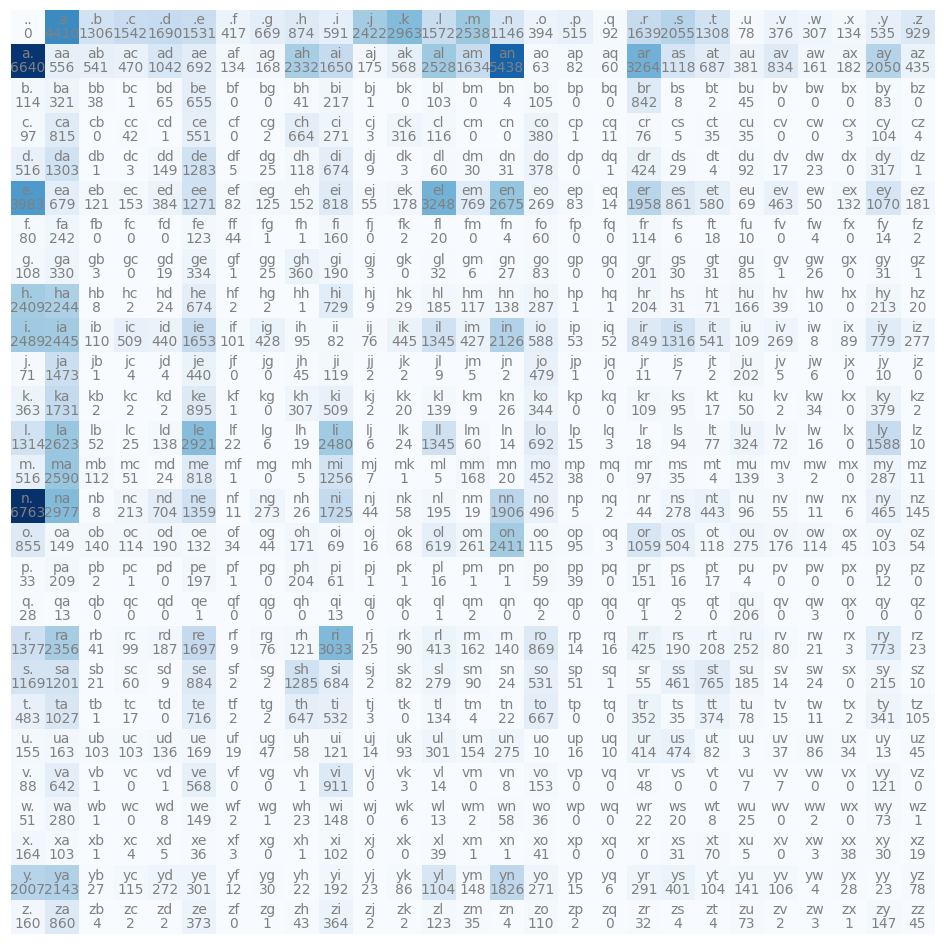

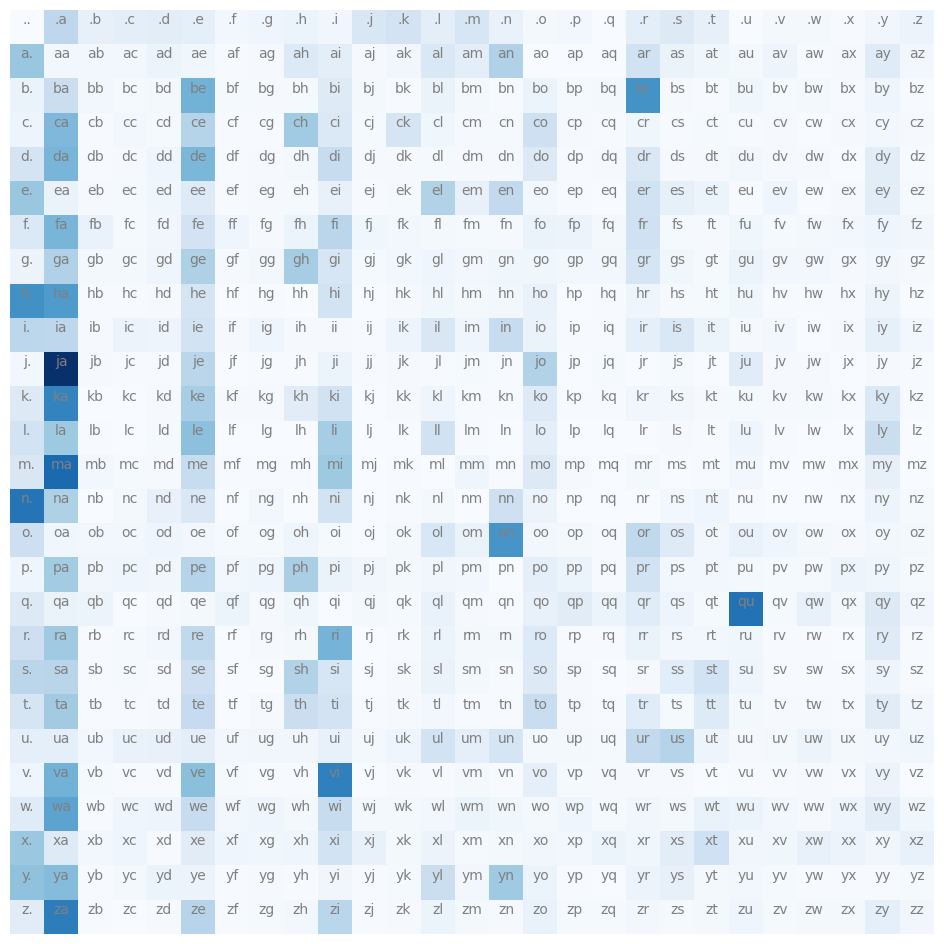

In [22]:
W_norm = torch.nn.functional.softmax(W, dim=1).detach().numpy()
plt.figure(figsize=(12, 12))
plt.imshow(W_norm, cmap="Blues")
for i in range(len(tokens)):
    for j in range(len(tokens)):
        ch1 = itos[i]
        ch2 = itos[j]
        plt.text(j, i, f"{ch1}{ch2}", ha="center", va="bottom", color="gray")
        # plt.text(j, i, f"{W[i, j].item()}", ha="center", va="top", color="gray")
plt.axis("off")
plt.show()